## Code for Music Generation

* Author: [Realsanjeev](https://realsanjeev.github.io/)

**This code was originally developed as part of my undergraduate Major Project.** The core implementation remains unchanged; however, it has been updated to work with newer versions of the required libraries. Additionally, some preprocessing steps were shortened to ensure quick run of the notebook.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import json
import glob
import pickle
import music21 as m21
import numpy as np

import tensorflow as tf
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [9]:
DATA_PATH = "/content/drive/MyDrive/essen-dataset/*"
midi_file_paths = glob.glob(DATA_PATH)[:50]
print(f'Total files in dataset: {len(midi_file_paths)}')

Total files in dataset: 50


## Extract features from the Dataset

In [10]:
def get_musical_data(song):
    pitches = []
    durations = []
    # Use notesAndRests for better efficiency and to ignore non-musical elements
    for element in song.flat.notesAndRests:
        if isinstance(element, m21.chord.Chord):
            if element.duration.quarterLength > 4:
                print(f"Skipping long Chord: {'.'.join(n.nameWithOctave for n in element.pitches)} and duration: {element.duration.quarterLength}")
                continue
            # Sort pitches alphabetically to ensure C-E-G is the same as E-G-C (reduces vocabulary)
            sorted_pitches = sorted([n.nameWithOctave for n in element.pitches])
            pitches.append('.'.join(sorted_pitches))
            durations.append(element.duration.quarterLength)
        elif isinstance(element, m21.note.Rest):
            if element.duration.quarterLength > 4:
                print(f"Skipping long Rest and duration: {element.duration.quarterLength}")
                continue
            pitches.append('rest')
            durations.append(element.duration.quarterLength)
        elif isinstance(element, m21.note.Note):
            if element.duration.quarterLength > 4:
                continue
            # Handle single notes explicitly
            pitches.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength)
    return pitches, durations

## Transponse music into C major/ A minor

In [11]:
def normalize_key(song):
    "Transposes song to C maj/A min for vocabulary consistency"
    # Default interval is 0 (no transposition) if key can't be determined
    interval = m21.interval.Interval(0)

    try:
        key = song.analyze("key")
        if key.mode == "major":
            interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
        elif key.mode == "minor":
            interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    except:
        print("Error: Key analysis failed. Using default no-transposition interval.")
        # If key analysis fails, we stick with the default no-transposition interval
        pass

    # transpose song by calculated interval
    normalized_song = song.transpose(interval)
    return normalized_song

In [12]:
dataset_pitches, dataset_durations = [], []
failed_transpose_count = 0

for file_path in tqdm(midi_file_paths):
  try:
    song = m21.converter.parse(file_path).chordify()
    try:
      song = normalize_key(song)
    except Exception as e:
      print(f'Cannot normalize key for {file_path}: {e}')
      failed_transpose_count += 1
      continue
    pitches_song, durations_song = get_musical_data(song)
    if pitches_song: # Only add if song has valid notes
        dataset_pitches.append(pitches_song)
        dataset_durations.append(durations_song)
  except Exception as err:
    print(f'Failed to parse file at path: {file_path} due to {err}')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [13]:
print(f'Length of a sample music: {len(dataset_durations[0])}')

Length of a sample music: 39


In [14]:
def get_unique_tokens(elements):
    # Get all unique element names (tokens)
    token_names = sorted(set(elements))
    n_tokens = len(token_names)
    return (token_names, n_tokens)

In [15]:
def create_vocabulary_mappings(token_names):
    # create dictionaries to map tokens to integers and vice-versa
    token_to_int = dict((str(token), number) for number, token in enumerate(token_names))
    int_to_token = dict((number, str(token)) for number, token in enumerate(token_names))
    return (token_to_int, int_to_token)

In [16]:
def save_vocabulary_files(token_to_int, int_to_token,
                          file1, file2):
    # save vocabulary mappings to json files
    with open(file1, 'w') as f:
        json.dump(token_to_int, f)
        print('Saved vocabulary file: ', file1)
    with open(file2, 'w') as f:
        json.dump(int_to_token, f)
        print('Saved vocabulary file: ', file2)

In [17]:
def load_vocabulary_files(file1, file2):
    # load vocabulary mapping from json files
    with open(file1) as f1:
        token_to_int = json.load(f1)
    with open(file2) as f2:
        int_to_token = json.load(f2)
    return token_to_int, int_to_token

In [18]:
# convert nested list to single flat list for vocabulary building
flat_pitches, flat_durations = [], []
for pitches, durations in zip(dataset_pitches, dataset_durations):
  for p, d in zip(pitches, durations):
    flat_pitches.append(p)
    flat_durations.append(d)

In [19]:
unique_pitches, n_unique_pitches = get_unique_tokens(flat_pitches)
unique_durations, n_unique_durations = get_unique_tokens(flat_durations)

# cleanup temporary flat lists
del flat_pitches
del flat_durations

In [20]:
pitch_to_int, int_to_pitch = create_vocabulary_mappings(unique_pitches)
duration_to_int, int_to_duration = create_vocabulary_mappings(unique_durations)

In [21]:
# saving vocabulary mappings
save_vocabulary_files(pitch_to_int, int_to_pitch,
                     'notes_int.json', 'int_notes.json')
save_vocabulary_files(duration_to_int, int_to_duration,
                     'durations_int.json', 'int_durations.json')

Saved vocabulary file:  notes_int.json
Saved vocabulary file:  int_notes.json
Saved vocabulary file:  durations_int.json
Saved vocabulary file:  int_durations.json


In [22]:
def prepare_input_sequences(pitches_dataset, durations_dataset,
                           pitch_to_int, int_to_pitch,
                           duration_to_int, int_to_duration,
                           n_unique_pitches, n_unique_durations,
                           seq_len=32):
    pitch_input_sequences = []
    pitch_targets = []
    duration_input_sequences = []
    duration_targets = []

    for pitches, durations in zip(pitches_dataset, durations_dataset):
        # create input sequences and the corresponding outputs
        for i in range(len(pitches) - seq_len):
            pitch_seq_in = pitches[i:i + seq_len]
            pitch_seq_out = pitches[i + seq_len]
            pitch_input_sequences.append([pitch_to_int[p] for p in pitch_seq_in])
            pitch_targets.append(pitch_to_int[pitch_seq_out])

            duration_seq_in = durations[i:i + seq_len]
            duration_seq_out = durations[i + seq_len]
            duration_input_sequences.append([duration_to_int[str(d)] for d in duration_seq_in])
            duration_targets.append(duration_to_int[str(duration_seq_out)])

    n_patterns = len(pitch_input_sequences)
    if n_patterns == 0:
        print(f"Error: No sequences generated. Dataset might be too short for seq_len={seq_len}")
        return None, None

    # reshape the input into a format compatible with LSTM layers
    pitch_input_sequences = np.reshape(pitch_input_sequences, (n_patterns, seq_len))
    duration_input_sequences = np.reshape(duration_input_sequences, (n_patterns, seq_len))
    network_input = [pitch_input_sequences, duration_input_sequences]

    pitch_targets = tf.keras.utils.to_categorical(pitch_targets, num_classes=n_unique_pitches)
    duration_targets = tf.keras.utils.to_categorical(duration_targets, num_classes=n_unique_durations)
    network_output = [pitch_targets, duration_targets]
    return (network_input, network_output)

In [23]:
notes_in = tf.keras.layers.Input(shape = (None,))
durations_in = tf.keras.layers.Input(shape = (None,))

In [24]:
notes_in

<KerasTensor shape=(None, None), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [25]:
network_input, network_output = prepare_input_sequences(dataset_pitches, dataset_durations,
                                                  pitch_to_int, int_to_pitch,
                                                  duration_to_int, int_to_duration,
                                                  n_unique_pitches,
                                                  n_unique_durations,
                                                  seq_len=16)

In [26]:
network_input[1].shape

(1621, 16)

In [27]:
network_input[1][1]

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1])

In [28]:
np.unique(network_input[:][1])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [29]:
print('pitch input shape:', network_input[0][0].shape)
print('duration input shape:', network_input[1][0].shape)
print('pitch target shape:', network_output[0][0].shape)
print('duration target shape:', network_output[1][0].shape)

pitch input shape: (16,)
duration input shape: (16,)
pitch target shape: (33,)
duration target shape: (8,)


In [66]:
def plot_loss_track(history):
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch, history.history['loss'], label='total loss')
  plt.plot(history.epoch, history.history['pitch_loss'], label='pitch loss')
  plt.plot(history.epoch, history.history['duration_loss'], label='duration loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.epoch, history.history['val_loss'], label='total loss')
  plt.plot(history.epoch, history.history['val_pitch_loss'], label='pitch loss')
  plt.plot(history.epoch, history.history['val_duration_loss'], label='duration loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Validation loss')
  plt.legend()
  plt.show()

In [67]:
def plot_accuracy_track(history):
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch, history.history['pitch_accuracy'], label='pitch accuracy')
  plt.plot(history.epoch, history.history['duration_accuracy'], label='duration accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.title(f'Training accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.epoch, history.history['val_pitch_accuracy'], label='pitch accuracy')
  plt.plot(history.epoch, history.history['val_duration_accuracy'], label='duration accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.title(f'Validation accuracy')
  plt.legend()
  plt.show()

In [32]:
#  Good valdation loss in but not good for train
# d_REGULIZAR = 'l1'
# p_REGULIZAR = 'l1_l2'

In [33]:
# Hyperparameters
pitch_embed_size = 128
duration_embed_size = 32 # Durations typically have smaller vocabulary
learning_rate = 0.001

# Regularization strategy: Dropout is generally better than L1/L2 for this task.
# We'll stick with None for kernel regularizers and rely on the Dropout layers.
d_REGULIZAR = None
p_REGULIZAR = None

### Model overview

This model is a **sequence-to-label neural network** designed to jointly predict the **next musical pitch and its duration** from a sequence of prior notes. It treats pitch and duration as two related but distinct modalities, learning a shared temporal representation before branching into separate prediction heads.

The architecture begins with **two parallel embedding pipelines**, one for pitches and one for durations. Each input token is mapped into a dense, continuous embedding space that captures semantic relationships (e.g., similarity between pitches or rhythmic values). These embeddings are regularized early using spatial dropout to improve generalization.

The pitch and duration embeddings are then **concatenated and normalized**, forming a unified representation of musical events over time. This combined sequence is processed by a **stacked LSTM backbone**, which models long-term temporal dependencies such as melodic contour, harmonic progression, and rhythmic structure. Dropout layers between LSTMs reduce overfitting while preserving temporal learning capacity.

After the final LSTM layer, the sequence is collapsed into a **single context vector**, representing a learned summary of the entire input phrase. This vector is normalized and passed through a dense projection layer to produce a compact, expressive latent representation.

From this shared latent space, the network branches into **two independent softmax output heads**:

* one predicting the next pitch
* one predicting the next duration

Each head is trained with categorical cross-entropy loss, allowing the model to jointly learn pitch–rhythm relationships while optimizing each prediction task separately.

### Why SpatialDropout1D is used

**SpatialDropout1D** is applied immediately after the embedding layers to regularize the model more effectively than standard dropout for sequence data.

Unlike regular dropout, which randomly zeros individual embedding values, SpatialDropout1D:

* **drops entire embedding channels (dimensions)** across all timesteps
* forces the model to avoid relying on specific embedding features
* encourages more robust, distributed representations

This is especially important for embeddings because:

* Adjacent embedding dimensions are often **highly correlated**
* Standard dropout can introduce noisy partial information rather than meaningful regularization
* Spatial dropout prevents the model from “memorizing” specific pitch or duration features

In a music modeling context, this helps ensure the network learns **musical structure and temporal relationships**, rather than overfitting to specific pitch identities or rhythmic patterns.

In [39]:
x1 = tf.keras.layers.Embedding(n_unique_pitches, pitch_embed_size, name="NotesFeature")(notes_in)
x1 = tf.keras.layers.SpatialDropout1D(0.2)(x1)

x2 = tf.keras.layers.Embedding(n_unique_durations, duration_embed_size, name="DurationFeatures")(durations_in)
x2 = tf.keras.layers.SpatialDropout1D(0.2)(x2)

x = tf.keras.layers.Concatenate()([x1,x2])
x = tf.keras.layers.LayerNormalization()(x)

x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)

c = tf.keras.layers.LSTM(128)(x)
c = tf.keras.layers.LayerNormalization()(c)

c = tf.keras.layers.Dense(128, activation='relu')(c)
c = tf.keras.layers.Dropout(0.2)(c)

notes_out = tf.keras.layers.Dense(n_unique_pitches, activation = 'softmax',
                                  name = 'pitch',
                                  kernel_regularizer=p_REGULIZAR)(c)
durations_out = tf.keras.layers.Dense(n_unique_durations,
                                      activation = 'softmax', name = 'duration',
                                      kernel_regularizer=d_REGULIZAR)(c)
model = tf.keras.Model([notes_in, durations_in],
                       [notes_out, durations_out])


#model =tf.keras.models.load_model('early_checkpoint.h5')
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=[tf.keras.losses.CategoricalCrossentropy(),
                    tf.keras.losses.CategoricalCrossentropy()],
              optimizer=optimizer,
              metrics=['accuracy', 'accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NotesFeature        │ (None, None, 128) │      4,224 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DurationFeatures    │ (None, None, 32)  │        256 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, None, 128) │          0 │ NotesFeature[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, None, 32)  │          0 │ DurationFeatures… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 160) │          0 │ spatial_dropout1… │
│ (Concatenate)       │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 160) │        320 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, None, 256) │    427,008 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 256) │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, None, 128) │    197,120 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ lstm_5[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 33)        │      4,257 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 8)         │      1,032 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 782,569 (2.99 MB)

 Trainable params: 782,569 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

### Visualize the model

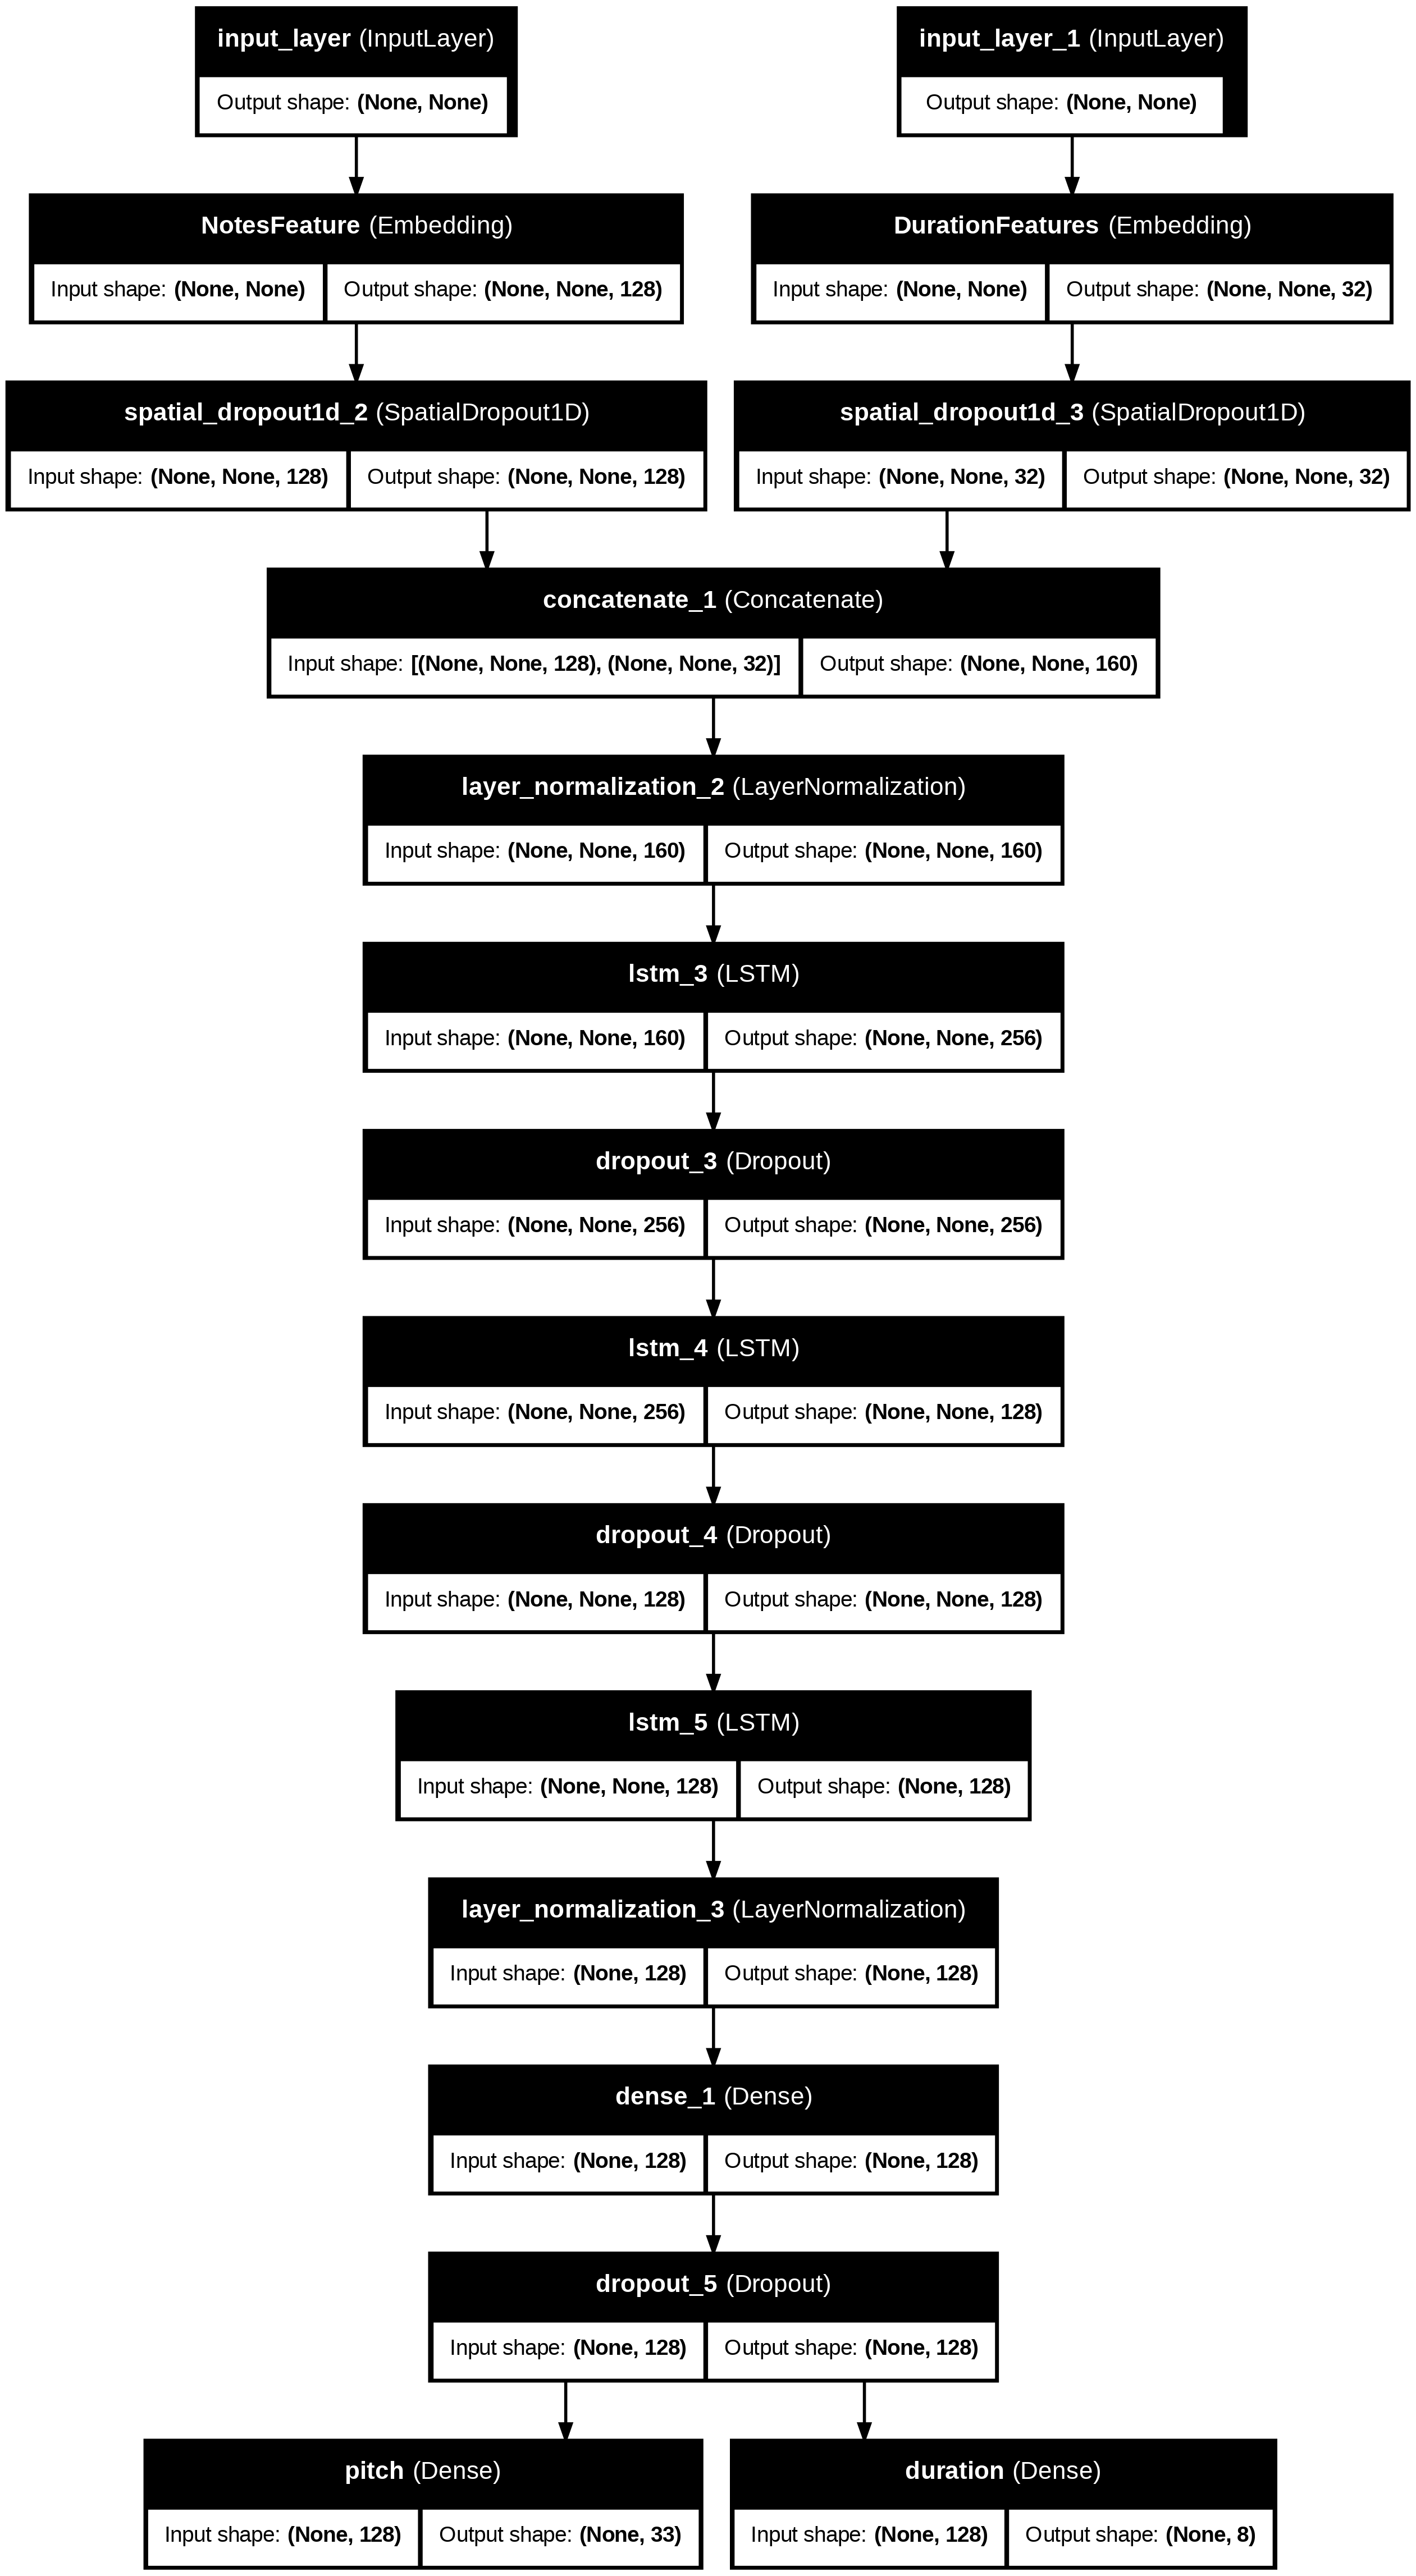

In [40]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, show_layer_names = True, expand_nested = True)

In [41]:
# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'early_checkpoint.keras',  # The filepath to save the model to
    monitor='loss',  # The criterion to use for saving the model
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model with the lowest validation loss
)

In [42]:
model.evaluate(network_input, network_output, return_dict=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - duration_accuracy: 0.0864 - duration_loss: 2.3388 - loss: 6.2420 - pitch_accuracy: 0.0292 - pitch_loss: 3.9030


{'duration_accuracy': 0.09438618272542953,
 'duration_loss': 2.354199171066284,
 'loss': 6.265883922576904,
 'pitch_accuracy': 0.02714373916387558,
 'pitch_loss': 3.9054739475250244}

In [43]:
model.fit(network_input, network_output
          , epochs=100, batch_size=64
          , validation_split = 0.2
          , shuffle=True
          , callbacks=[checkpoint_callback]
         )

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - duration_accuracy: 0.4222 - duration_loss: 1.6599 - loss: 4.8468 - pitch_accuracy: 0.1058 - pitch_loss: 3.1842 - val_duration_accuracy: 0.4492 - val_duration_loss: 1.5133 - val_loss: 3.9001 - val_pitch_accuracy: 0.1569 - val_pitch_loss: 2.4579
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - duration_accuracy: 0.5409 - duration_loss: 1.3343 - loss: 3.9009 - pitch_accuracy: 0.1755 - pitch_loss: 2.5658 - val_duration_accuracy: 0.4492 - val_duration_loss: 1.4463 - val_loss: 3.7590 - val_pitch_accuracy: 0.1631 - val_pitch_loss: 2.3971
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - duration_accuracy: 0.5342 - duration_loss: 1.3188 - loss: 3.7835 - pitch_accuracy: 0.1719 - pitch_loss: 2.4643 - val_duration_accuracy: 0.4492 - val_duration_loss: 1.4123 - val_loss: 3.6747 - val_pitch_accuracy: 0.1631 - val_pitch_loss: 2.3275
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - duration_accuracy: 0.5298 - duration_loss: 1.3091 - 

In [44]:
history = model.history

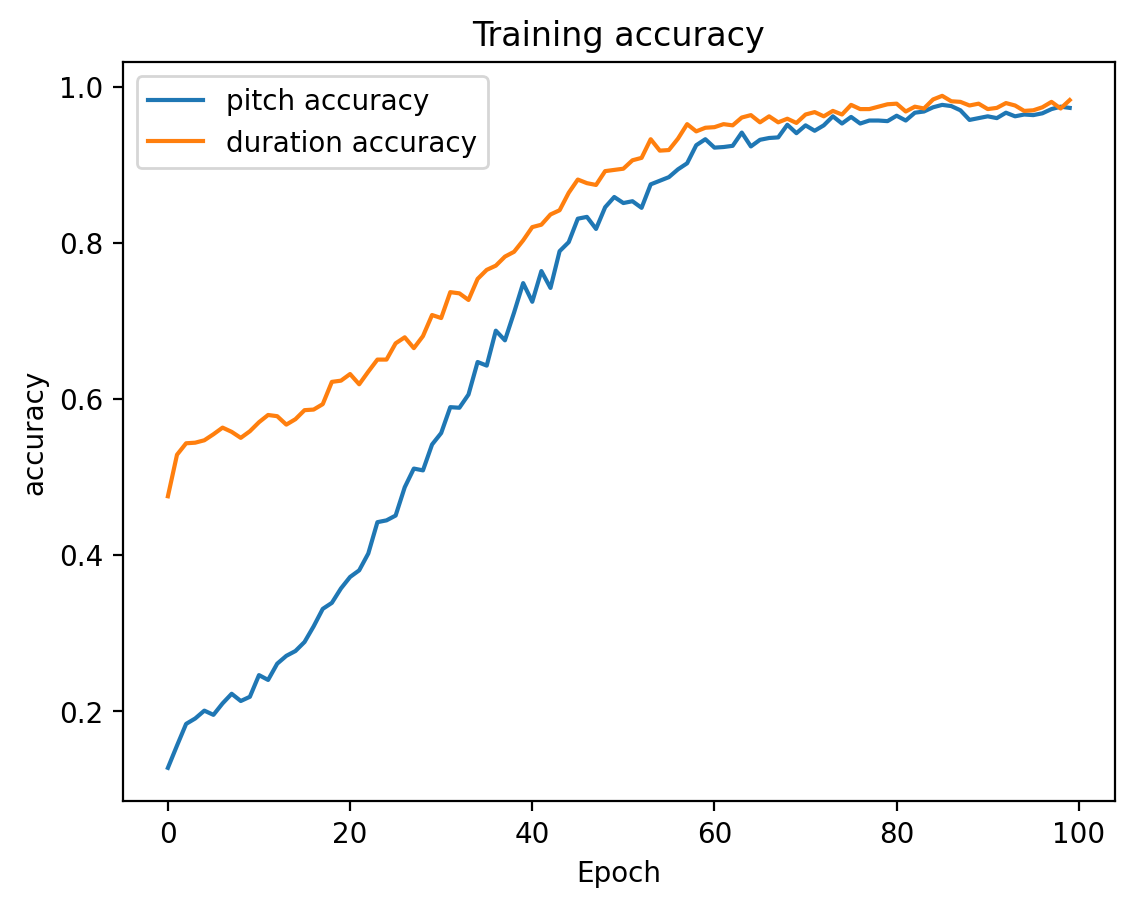

In [45]:
plt.plot(history.epoch, history.history['pitch_accuracy'], label='pitch accuracy')
plt.plot(history.epoch, history.history['duration_accuracy'], label='duration accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title(f'Training accuracy')
plt.legend()
plt.legend()

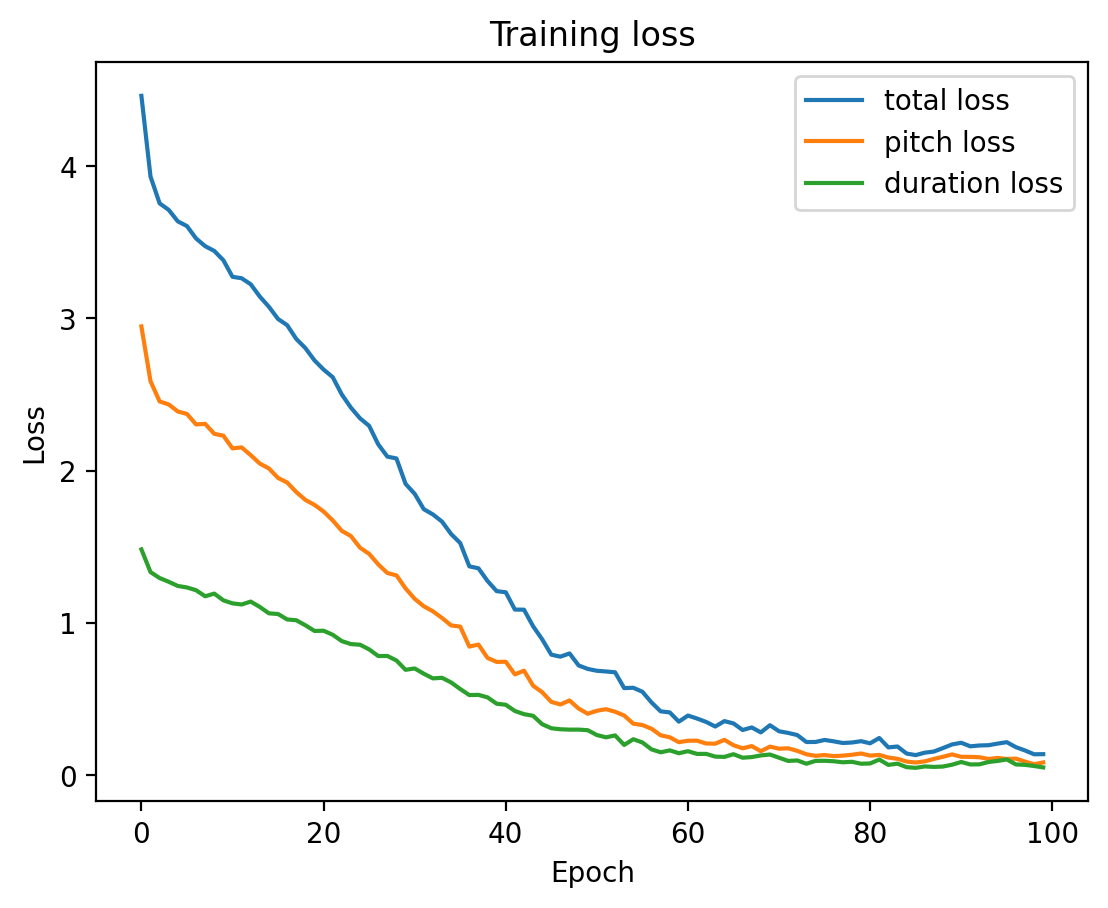

In [46]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.plot(history.epoch, history.history['pitch_loss'], label='pitch loss')
plt.plot(history.epoch, history.history['duration_loss'], label='duration loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training loss')
plt.legend()

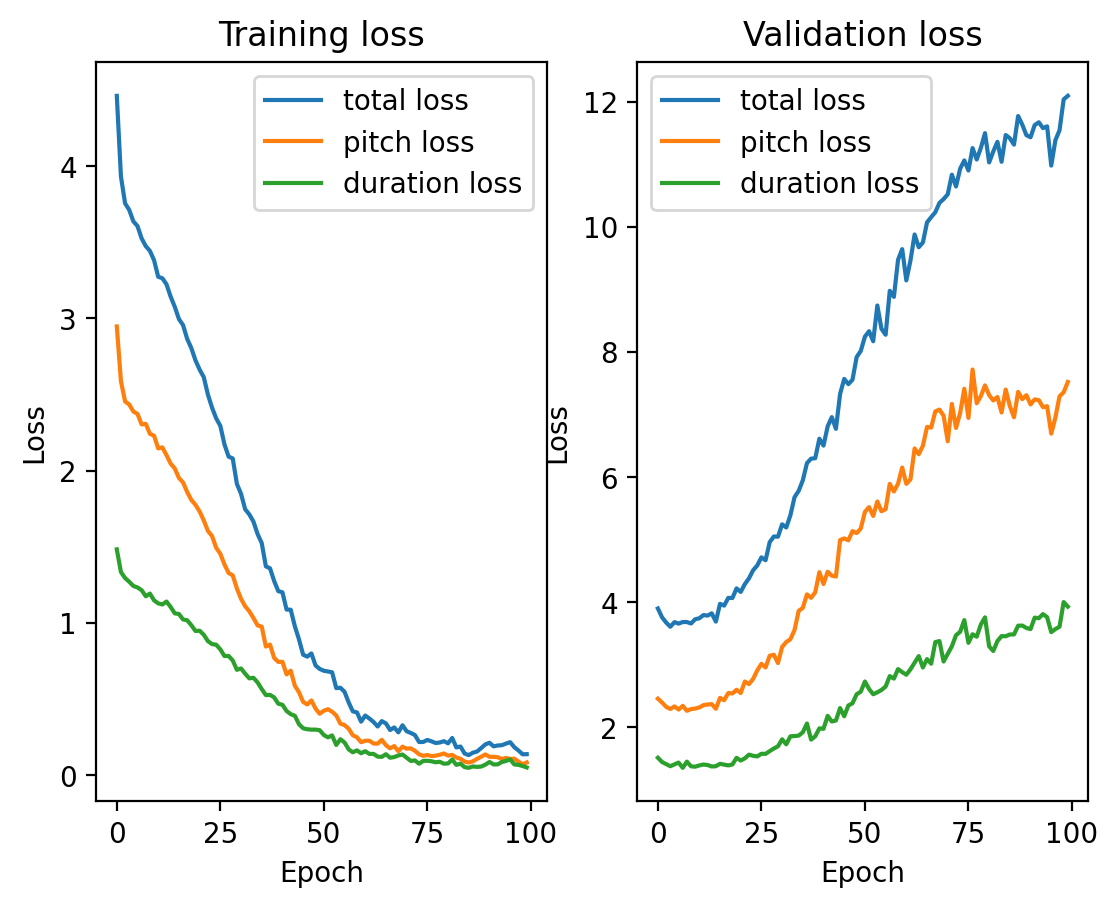

In [68]:
plot_loss_track(history)

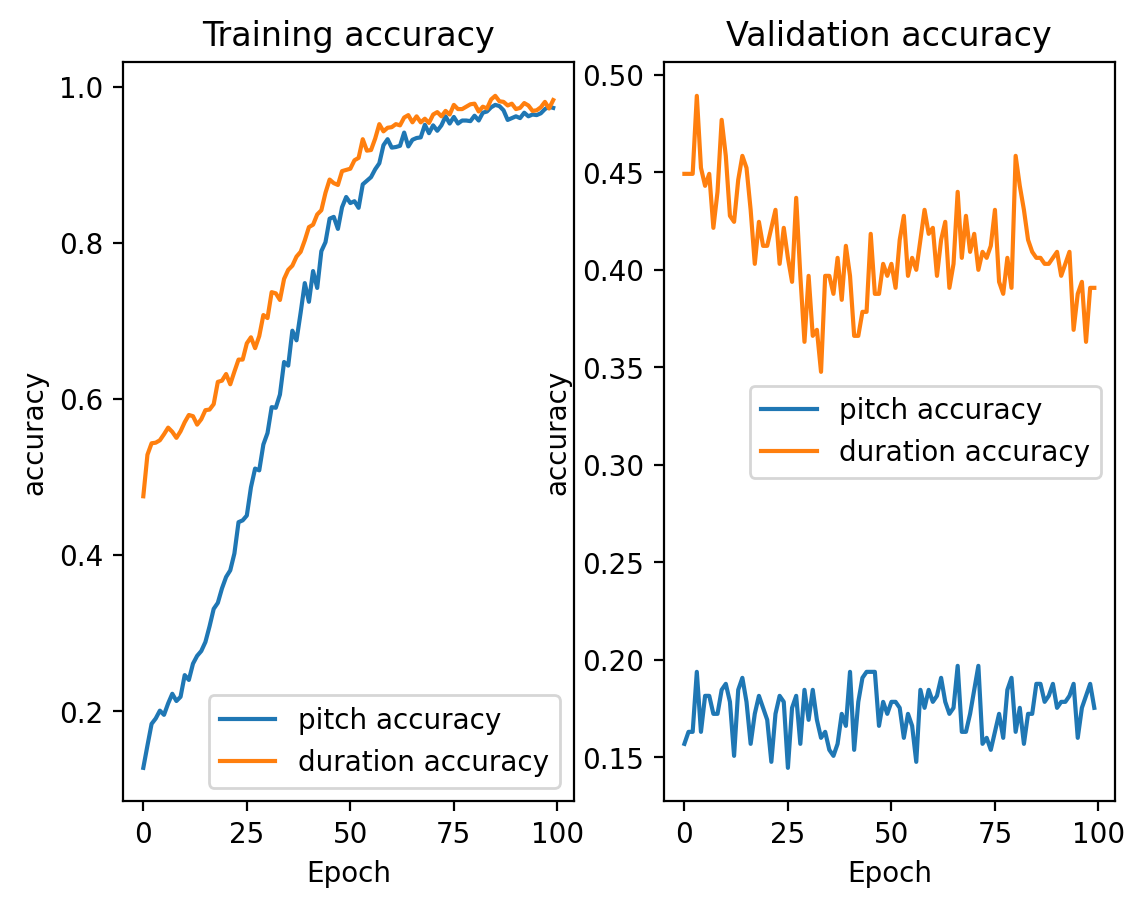

In [69]:
plot_accuracy_track(history)

### Inference

In [49]:
import music21 as m21
import os
import json
import numpy as np

import tensorflow as tf

In [50]:
# Load the best model saved during training
model = tf.keras.models.load_model('early_checkpoint.keras', compile=False)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NotesFeature        │ (None, None, 128) │      4,224 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DurationFeatures    │ (None, None, 32)  │        256 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, None, 128) │          0 │ NotesFeature[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, None, 32)  │          0 │ DurationFeatures… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 160) │          0 │ spatial_dropout1… │
│ (Concatenate)       │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 160) │        320 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, None, 256) │    427,008 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 256) │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, None, 128) │    197,120 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ lstm_5[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 33)        │      4,257 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 8)         │      1,032 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 782,569 (2.99 MB)

 Trainable params: 782,569 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def sample_with_temp(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [52]:
def load_decoder(file1, file2):
    # load json file
    with open(file1) as file1:
        element_to_int = json.load(file1)
        print(type(element_to_int))
    with open(file2) as f:
        int_to_element = json.load(f)
    return element_to_int, int_to_element

In [53]:
def fraction(duration):
    if '/' in duration:
        lst = duration.split('/')
        return int(lst[0])/int(lst[1])
    else:
        return float(duration)

def round_duration(duration):
    """Rhythmically round to nearest standard duration if needed"""
    standard_durations = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0]
    return min(standard_durations, key=lambda x:abs(x-duration))

In [54]:
# prediction params
pitch_sampling_temperature = 0.5
duration_sampling_temperature = 0.5
num_notes_to_generate = 100
seq_len = 16
max_seq_len = seq_len

In [55]:
# getting vocabulary mappings
# note_to_int, int_to_note = load_decoder('notes_int.json', 'int_notes.json')
# durations_to_int, int_to_duration = load_decoder('durations_int.json', 'int_durations.json')

int_to_pitch, int_to_duration = load_vocabulary_files('int_notes.json', 'int_durations.json')

In [56]:
# find range for random seed generation
n_unique_pitches = len(int_to_pitch)
n_unique_durations = len(int_to_duration)

# randomize seed for prediction
pitch_seed = np.random.randint(n_unique_pitches, size=seq_len)
duration_seed = np.random.randint(n_unique_durations, size=seq_len)

pitch_input_sequence = pitch_seed.tolist()
duration_input_sequence = duration_seed.tolist()

### Decode random seed

In [57]:
if dataset_pitches and len(dataset_pitches[0]) >= seq_len:
    # Pick a random song and a random starting point
    song_idx = np.random.randint(len(dataset_pitches))
    start_idx = np.random.randint(len(dataset_pitches[song_idx]) - seq_len)

    pitch_input_sequence = [pitch_to_int[p] for p in dataset_pitches[song_idx][start_idx:start_idx+seq_len]]
    duration_input_sequence = [duration_to_int[str(d)] for d in dataset_durations[song_idx][start_idx:start_idx+seq_len]]
    print(f"Using random snippet from dataset (song {song_idx}, start {start_idx}) as seed.")
else:
    print("Warning: Dataset empty or too short. Falling back to random integers for seed.")
    pitch_seed = np.random.randint(n_unique_pitches, size=seq_len)
    duration_seed = np.random.randint(n_unique_durations, size=seq_len)
    pitch_input_sequence = pitch_seed.tolist()
    duration_input_sequence = duration_seed.tolist()

Using random snippet from dataset (song 31, start 24) as seed.


In [58]:
decoded_seed = []
for pitch_index, duration_index in zip(pitch_input_sequence,
                                      duration_input_sequence):

    pitch_result = int_to_pitch[str(pitch_index)]
    duration_result = fraction(int_to_duration[str(duration_index)])

    decoded_seed.append([pitch_result, duration_result])

print(f'Decoded seed for prediction: {decoded_seed[:4]}')

Decoded seed for prediction: [['B3', 0.5], ['A3', 1.5], ['A3', 1.5], ['F4', 1.0]]


# predict music

In [59]:
# max_seq_len=16

In [60]:
generated_composition = []

for _ in range(num_notes_to_generate):

    model_input = [
        np.array([pitch_input_sequence])
        , np.array([duration_input_sequence])
       ]

    pitches_prediction, durations_prediction = model.predict(model_input, verbose=0)

    sampled_pitch_idx = sample_with_temp(pitches_prediction[0], pitch_sampling_temperature)
    sampled_duration_idx = sample_with_temp(durations_prediction[0], duration_sampling_temperature)

    pitch_result = int_to_pitch[str(sampled_pitch_idx)]
    # Apply rounding for better rhythmic consistency
    duration_result = round_duration(fraction(int_to_duration[str(sampled_duration_idx)]))

    generated_composition.append([pitch_result, duration_result])

    pitch_input_sequence.append(sampled_pitch_idx)
    duration_input_sequence.append(sampled_duration_idx)

    if len(pitch_input_sequence) > max_seq_len:
        pitch_input_sequence = pitch_input_sequence[1:]
        duration_input_sequence = duration_input_sequence[1:]

print('Generated sequence of {} notes'.format(len(generated_composition)))

Generated sequence of 100 notes


In [61]:
generated_composition

[['C4', 1.5],
 ['rest', 1.5],
 ['rest', 1.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['G4', 0.5],
 ['E5', 0.5],
 ['E4', 0.5],
 ['C4', 0.25],
 ['B3', 0.25],
 ['rest', 1.0],
 ['D4', 0.25],
 ['C4', 0.5],
 ['A3', 0.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['E4', 0.5],
 ['rest', 1.5],
 ['F4', 0.25],
 ['E4', 0.25],
 ['F4', 0.25],
 ['D4', 0.5],
 ['E4', 0.25],
 ['G4', 0.25],
 ['rest', 0.25],
 ['G4', 0.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['F4', 0.5],
 ['E4', 0.5],
 ['G4', 0.5],
 ['E4', 0.25],
 ['D4', 0.5],
 ['C4', 1.0],
 ['rest', 1.0],
 ['D4', 0.25],
 ['D4', 0.5],
 ['C4', 0.25],
 ['D4', 0.25],
 ['D4', 0.25],
 ['D4', 0.25],
 ['D4', 0.25],
 ['G4', 0.25],
 ['E4', 0.25],
 ['G4', 0.5],
 ['G4', 0.25],
 ['E4', 0.5],
 ['D4', 0.5],
 ['D4', 0.5],
 ['rest', 0.5],
 ['D4', 0.25],
 ['G4', 0.25],
 ['E4', 0.5],
 ['E4', 0.25],
 ['D4', 0.25],
 ['A3', 0.25],
 ['C4', 0.25],
 ['C5', 0.25],
 ['B4', 0.25],
 ['D4', 0.25],
 ['G4', 0.5],
 ['E4', 0.25],
 ['G4', 0.25],
 ['D4', 0.25],
 ['D4', 0.25],
 ['D4', 0.25],
 

In [62]:
def generate_midi_stream(composition_data,
                         instrument_name='Piano',
                         time_signature_val='4/4'):
    midi_stream = m21.stream.Stream()

    time_signature = m21.meter.TimeSignature(time_signature_val)
    instrument_obj = m21.instrument.fromString(instrument_name)
    midi_stream.insert(0.0, instrument_obj)
    midi_stream.append(time_signature)

    # create note and chord objects based on the values generated by the model
    for element in composition_data:
        pitch_pattern, duration_val = element

        # pitch_pattern is a chord
        if ('.' in pitch_pattern):
            notes_in_chord = pitch_pattern.split('.')
            chord_notes = []
            for note_name in notes_in_chord:
                new_note = m21.note.Note(note_name)
                new_note.duration = m21.duration.Duration(quarterLength=duration_val)
                chord_notes.append(new_note)
            new_chord = m21.chord.Chord(chord_notes)
            midi_stream.append(new_chord)
        elif pitch_pattern == 'rest':
            # element is a rest
            new_rest = m21.note.Rest()
            new_rest.duration = m21.duration.Duration(quarterLength=duration_val)
            midi_stream.append(new_rest)
        else:
            # element is a single note
            new_note = m21.note.Note(pitch_pattern)
            new_note.duration = m21.duration.Duration(quarterLength=duration_val)
            midi_stream.append(new_note)
    return midi_stream

generated_midi_stream = generate_midi_stream(generated_composition)

In [63]:
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
midi_filename = f'generated_composition_{timestamp}.mid'
generated_midi_stream.write('midi', midi_filename)

'generated_composition_20260107-102709.mid'

In [64]:
generated_midi_stream = generated_midi_stream.makeMeasures()
generated_midi_stream.show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano 'Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note C>
    {1.5} <music21.note.Rest dotted-quarter>
    {3.0} <music21.note.Rest dotted-quarter>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.5} <music21.note.Note F>
    {1.0} <music21.note.Note F>
    {1.5} <music21.note.Note G>
    {2.0} <music21.note.Note E>
    {2.5} <music21.note.Note E>
    {3.0} <music21.note.Note C>
    {3.25} <music21.note.Note B>
    {3.5} <music21.note.Rest quarter>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.5} <music21.note.Note D>
    {0.75} <music21.note.Note C>
    {1.25} <music21.note.Note A>
    {1.75} <music21.note.Note F>
    {2.25} <music21.note.Note F>
    {2.75} <music21.note.Note E>
    {3.25} <music21.note.Rest dotted-quarter>
{12.0} <music21.stream.Measure 4 offset=12.0>
    {0.75} <music21.note.Note F>
    {1.0} <music21.note.Note E>
    

In [65]:
from google.colab import files
files.download(midi_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>